In [1]:
%matplotlib inline
import numpy as np
import os

import matplotlib.pyplot as plt

import strawb
import scipy.ndimage
import scipy.spatial
import scipy.interpolate

# Load images with turned on LED lights

In [5]:
# load the images
with np.load('LED_images.npz') as f:
    images = f['images']

#### Select a bright image

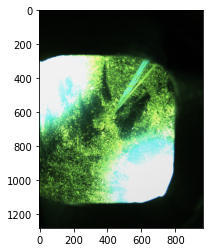

In [6]:
# select one bright image
image = images[4]

# show the selected image
plt.figure()
plt.imshow(image)

### Separate RGB colors and mask area with dark pixels

In [7]:
# create arrays with individual color information
blue = image[:,:,2]
green = image[:,:,1]
red = image[:,:,0]

# make a mask for every color that selects dark pixels with a charge below a threshold d
d = 0.15
mounting_blue = blue < d
mounting_green = green < d
mounting_red = red < d

# combine the color masks
mounting = mounting_blue & mounting_green & mounting_red 

## Label clusters in mounting

In [8]:
# define the structure of the clusters so that diagonal pixels are considered neighbours
s = scipy.ndimage.generate_binary_structure(2,2)  

mounting_labeled, n = scipy.ndimage.measurements.label(mounting, structure=s)  # array with labels as values

mask = mounting_labeled == mounting_labeled[-1]
mask = ~mask  # invert the mask

mask_labeled, n_mask = scipy.ndimage.measurements.label(mask, structure=s)  

# compute cluster sizes (number of pixels) in mask
mask_area = scipy.ndimage.measurements.sum(mask, mask_labeled, index=np.arange(mask_labeled.max() + 1)) 

mask_size = mask_area[mask_labeled]  # set value of each pixel to the size of the cluster it belongs to 

## Mask for the field of view of the camera

In [9]:
# biggest cluster is the field of view of the camera
view_camera = np.where(mask_size == mask_area.max(), True, False)  

## Mask for the mounting coordinates

In [10]:
mask_mounting = ~view_camera  # inverse of the field of view of the camera

# save the mask in separate file
file_name = os.path.abspath(os.path.join(strawb.Config.repository_home,
                                         'src/strawb/sensors/camera/mounting_mask.npz'))
np.savez(file_name, TUMPMTSPECTROMETER001=mask_mounting)

### Show the mounting and field of view of the camera

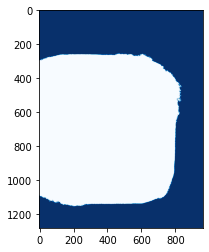

In [11]:
plt.figure()
plt.imshow(view_camera, cmap='Blues_r')
plt.show()

## Coordinates of the pixels that belong to the mounting 

In [12]:
# coordinates of all pixels that belong to the field of view of the camera
view_camera_coo = np.argwhere(view_camera == True)

# coordinates of all pixels that belong to the mounting
mounting_coo = np.argwhere(view_camera == False)